In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy import interpolate
from scipy.special import factorial2
from scipy.interpolate import splrep, splev
from scipy.special import comb
from numpy.polynomial.hermite import hermgauss
from py_vollib.black_scholes.implied_volatility import implied_volatility
vec_find_vol_rat = np.vectorize(implied_volatility)   #imp vol estimator based on P Jäckel Let's be rational
from py_vollib.black_scholes.implied_volatility import implied_volatility as bs_iv
import numpy as np
import scipy
from scipy import interpolate
from numpy import pi, sqrt, exp


In [2]:
def horner_vector(poly, x):
    result = poly[0] * np.ones_like(x)
    for coeff in poly[1:]:
        result = result * x + coeff
    return result

def make_fv_curve_interpolator(T_array, fv_array):
    from scipy.interpolate import interp1d
    return interp1d(T_array, fv_array, kind='cubic', fill_value='extrapolate')

def vec_find_vol_rat(prices, S0, strikes, T, flag, r=0.0):
    def safe_iv(price, K):
        try:
            return implied_volatility(price, S0, K, T, r, flag)
        except Exception as e:
            print(f"IV error for price={price:.4f}, K={K:.2f}: {e}")
            return np.nan
    return np.vectorize(safe_iv)(prices, strikes)




In [3]:
class OneQuinticOU():
    def __init__(self, eps, H, T, n_steps, N_sims, S0, rho, a_k):
        self.eps = eps
        self.H = H
        self.T = T
        self.n_steps = n_steps
        self.N_sims = N_sims
        self.S0 = S0
        self.rho = rho
        self.a_k = a_k

    def simulate_OU_X(self):
        dt = self.T / self.n_steps
        X = np.zeros((self.N_sims, self.n_steps))
        X[:, 0] = np.random.normal(loc=1, scale=np.sqrt(2), size=self.N_sims)

        trajectories = np.zeros_like(X)
        Y_storage = np.zeros_like(X)

        kappa = (0.5 - self.H) / self.eps
        beta = np.sqrt(self.eps ** (2 * self.H) / (1 - 2 * self.H))

        for i in range(1, self.n_steps):
            Z = np.random.randn(self.N_sims)
            dX = beta * (np.exp(kappa * i * dt / 2) - np.exp(kappa * (i - 1) * dt)) * Z
            X[:, i] = X[:, i - 1] + dX
            alpha = np.exp((0.5 - self.H) * (-i * dt) / self.eps)
            trajectories[:, i] = alpha * X[:, i]
            Y_storage[:, i] = Z

        self.X = trajectories
        self.Y_storage = Y_storage
        return Y_storage, trajectories

    def sigma(self, ksi_0):
        poly_vals = horner_vector(self.a_k, self.X)
        f_X_squared = poly_vals ** 2
        expected_fx2 = np.mean(f_X_squared, axis=0) + 1e-10
        t_grid = np.linspace(0, self.T, self.n_steps)
        ksi_vals = ksi_0(t_grid)
        sigma_squared = f_X_squared * ksi_vals[None, :] / expected_fx2[None, :]
        self.sigma_t = np.sqrt(sigma_squared)
        return self.sigma_t

    def simulate_logS_batched(self):
        dt = self.T / self.n_steps
        log_S = np.zeros((self.N_sims, self.n_steps))
        log_S[:, 0] = np.log(self.S0)
        for i in range(1, self.n_steps):
            sigma_prev = self.sigma_t[:, i - 1]
            drift = -0.5 * (self.rho * sigma_prev) ** 2 * dt
            diffusion = self.rho * sigma_prev * np.sqrt(dt) * self.Y_storage[:, i - 1]
            log_S[:, i] = log_S[:, i - 1] + drift + diffusion
        self.log_S = log_S
        return log_S

    def run_pipeline(self, ksi_0_func, flag='c', r=0.0):
        self.simulate_OU_X()
        self.sigma(ksi_0_func)
        log_S = self.simulate_logS_batched()
        S_T = np.exp(log_S[:, -1])
        
        lm = np.linspace(-0.5, 0.35, 50)
        strike_array = self.S0 * np.exp(lm)
        call_payoffs = np.maximum(S_T[:, None] - strike_array, 0)
        call_prices = np.mean(call_payoffs, axis=0)

        imp_vols = vec_find_vol_rat(call_prices, self.S0, strike_array, self.T, flag, r)
        intrinsic_values = np.maximum(self.S0 - strike_array, 0)
        valid = call_prices > intrinsic_values + 1e-4
        return strike_array[valid], imp_vols[valid]


In [4]:
def horner_vector(poly, x):
    result = poly[0] * np.ones_like(x)
    for coeff in poly[1:]:
        result = result * x + coeff
    return result

def vec_find_vol_rat(prices, S0, strikes, T, flag, r=0.0):
    def safe_iv(price, K):
        try:
            return implied_volatility(price, S0, K, T, r, flag)
        except Exception as e:
            print(f"IV error for price={price:.4f}, K={K:.2f}: {e}")
            return np.nan
    return np.vectorize(safe_iv)(prices, strikes)


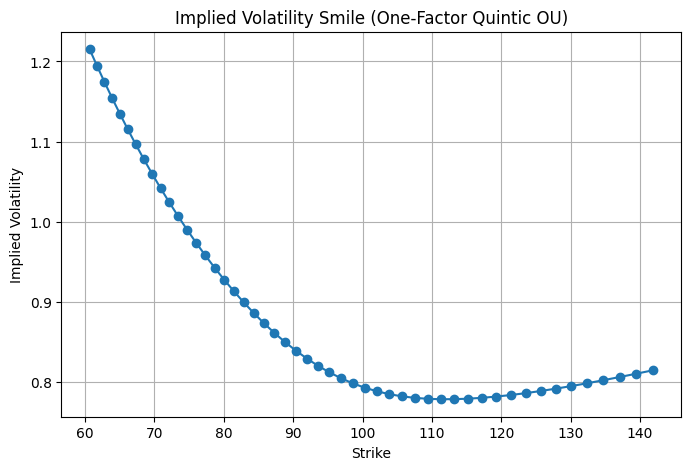

In [5]:
# ==== PARAMÈTRES ====
eps = 1 / 52
H = 0.1
a_k = [0.01, 0, 0.01, 0, 0.001, 0.5]
T = 1
n_steps = 1000
N_sims = 40000
S0 = 100
rho = 0.85

# Courbe de variance à terme
T_array_nodes = np.array([0, 0.5, 1.0, 1000])
fv_nodes = np.array([0.04, 0.04, 0.04, 0.4])
fv_func = make_fv_curve_interpolator(T_array_nodes, fv_nodes)

# ==== SIMULATION ET SMILE ====
model = OneQuinticOU(eps, H, T, n_steps, N_sims, S0, rho, a_k)
strikes, iv_smile = model.run_pipeline(fv_func)

# ==== PLOT ====
plt.figure(figsize=(8, 5))
plt.plot(strikes, iv_smile, marker='o')
plt.title("Implied Volatility Smile (One-Factor Quintic OU)")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.grid(True)
plt.show()


In [6]:
import numpy as np
from numpy import pi, sqrt, exp
from scipy.special import factorial2, comb
from scipy.interpolate import splrep, splev
from py_vollib.black_scholes.implied_volatility import implied_volatility


def horner_vector(coeffs, n, x):
    """Efficient evaluation of a polynomial using Horner’s method.
       Evaluates: f(x) = a_0 + a_1 x + ... + a_n x^n
       Vectorized for input array x."""
    result = coeffs[0] * np.ones_like(x)
    for c in coeffs[1:]:
        result = result * x + c
    return result

def gauss_dens(mu, sigma, x):
    """Standard Gaussian density function."""
    return 1 / (sqrt(2 * pi) * sigma) * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

def vec_find_vol_rat(prices, S0, strikes, T, r, flag):
    """Vectorized implied volatility computation with error handling."""
    def safe_iv(price, K):
        try:
            return implied_volatility(price, S0, K, T, r, flag)
        except Exception:
            return np.nan
    return np.vectorize(safe_iv)(prices, strikes)

class VIX_One_QUINTIC:
    def __init__(self, eps, H, n_steps, delta, a_k, T=1/12, ub_vix=8.0, lb_vix=-8.0):
        # Rough volatility model parameters
        self.eps = eps
        self.H = H
        self.n_steps = n_steps  # Discretization steps for integration
        self.delta = delta      # VIX averaging window (e.g. 30 days)
        self.a_k = np.array(a_k)  # Coefficients of polynomial f(x)
        self.T = T              # Current time (e.g. 1 month = 1/12)
        self.ub_vix = ub_vix    # Upper bound for integration
        self.lb_vix = lb_vix    # Lower bound for integration
        self.beta = None        # Will hold β_i coefficients

    def compute_beta_vector_full(self, ksi_0):
        """
        Compute the constant coefficients β_i appearing in the quadratic-form
        representation of VIX² under the Quintic-OU rough-vol model.

        Mathematically we want
            VIX_T² = 1/Δ ∫_{T}^{T+Δ} f(X_t)² ξ₀(t) dt
                    = Σ_{i=0}^{2n-2} β_i X_T^i,           (1)

        where
          • f(x) = Σ_{k=0}^{n-1} a_k x^k   is our quintic (degree n-1) polynomial,
          • X_t  is the rough mean-reverting factor (OU-type),
          • ξ₀(t) is the *forward variance curve* passed as callable `ksi_0`,
          • Δ    = self.delta (30 days / 360 by default).

        The inner time integral is evaluated with the trapezoidal rule on a
        uniform grid of `n_steps + 1` points.  For every grid point tⱼ we first
        compute β_i(tⱼ) and finally integrate in time to obtain β_i.
        """
        # ------------------ 1) Discretisation of the [T, T+Δ] interval ---------
        n        = len(self.a_k)                     # degree of f plus one
        T_delta  = self.T + self.delta               # upper limit T + Δ
        dt       = (T_delta - self.T) / self.n_steps # grid spacing Δt
        tt       = np.linspace(self.T, T_delta, self.n_steps + 1)  # time grid

        # -------------- 2) Kernel-specific constants & helper arrays ----------
        kappa_tild = (0.5 - self.H) / self.eps            # λ̃  in paper
        eta_tild   = self.eps ** (self.H - 0.5)           # η̃  prefactor

        # Standard deviation of the *kernel‐integrated* Gaussian G(s,t)
        std_Gs_T = eta_tild * np.sqrt(
            1 / (2 * kappa_tild) * (1 - np.exp(-2 * kappa_tild * (tt - self.T)))
        )  # shape (n_steps+1,)

        # Standard deviation of X_t itself at each tⱼ
        std_X_t = eta_tild * np.sqrt(
            1 / (2 * kappa_tild) * (1 - np.exp(-2 * kappa_tild * tt))
        )  # shape (n_steps+1,)

        # Exponential decay term exp(-λ̃ (tⱼ − T))
        exp_det = np.exp(-kappa_tild * (tt - self.T))      # shape (n_steps+1,)

        # ---------------- 3) Coefficients of f(x)²  ---------------------------
        #   f(x)² = (Σ a_k x^k)² = Σ_{m=0}^{2n-2} c_m x^m,  where
        #   c_m = Σ_{k=0}^m a_k a_{m-k}
        cauchy_product = np.convolve(self.a_k, self.a_k)   # length 2n-1

        # --------------- 4) Normalisation  E[f(X_t)²]  -------------------------
        #   Denominator appearing in β_i(t) definition.
        even_indices = np.arange(0, 2 * n, 2)              # 0,2,4,…,2n-2
        double_fac   = factorial2(even_indices - 1)        # (k-1)!! for those k

        # Broadcasting shapes:
        #   cauchy_product[even]          -> (neven ,)
        #   std_X_t ** even[:,None]       -> (neven , ngrid)
        normal_var = np.sum(
            cauchy_product[even_indices][:, None]          # c_k
            * std_X_t[None, :] ** even_indices[:, None]    # σ_X^k
            * double_fac[:, None],                         # (k-1)!!
            axis=0                                         # result shape (ngrid,)
        )
        # guard against division by zero
        normal_var = np.maximum(normal_var, 1e-16)

        # --------------- 5) Forward variance curve ξ₀(t) -----------------------
        ksi_vals = ksi_0(tt)                               # shape (ngrid,)

        # --------------- 6) Compute β_i(tⱼ) for each i, tⱼ ---------------------
        # We build a list beta_all where beta_all[i, j] = β_i(t_j)
        beta_all = []
        for i in range(2 * n - 1):                         # i = 0 … 2n-2
            # All k ≥ i that contribute to β_i(t) according to the
            # binomial expansion in the paper.
            k_array = np.arange(i, 2 * n - 1)              # shape (kdim,)
            combs   = comb(k_array, i).reshape(-1, 1)      # binom(k,i)

            # (k-i-1)!!  appears only if (k-i) is odd, else zero
            double_fac_i = np.array([
                factorial2(k - i - 1) if (k - i - 1) >= 0 else 0
                for k in k_array
            ]).reshape(-1, 1)                              # shape (kdim,1)

            # 1 for odd (k-i), 0 for even — enforces odd-power condition
            odd_mask = ((k_array - i - 1) % 2).reshape(-1, 1)

            # Assemble the contribution of each k to β_i(t_j)
            beta_temp = (
                std_Gs_T[None, :] ** (k_array - i).reshape(-1, 1)  # σ_G^(k-i)
                * odd_mask                                         # keep odd terms
                * double_fac_i                                     # (k-i-1)!!
                * combs                                            # binomial(k,i)
                * exp_det[None, :] ** i                            # e^{-λ̃ (t-T) i}
                * cauchy_product[k_array].reshape(-1, 1)           # c_k
            )  # shape (kdim , ngrid)

            # Sum over k dimension → β_i(t_j) for each t_j
            beta_all.append(np.sum(beta_temp, axis=0))             # shape (ngrid,)

        # Stack into array of shape (2n-1 , ngrid)
        beta_all = np.array(beta_all)

        # --------------- 7) Multiply by ξ₀(t) / E[f(X_t)²]  -------------------
        beta_all = beta_all * ksi_vals / normal_var              # element-wise

        # --------------- 8) Integrate in t (trapezoidal rule)  ----------------
        # β_i = ∫ β_i(t) dt  ≈  Σ_j ½[β_i(t_j)+β_i(t_{j+1})] Δt
        self.beta = np.sum((beta_all[:, :-1] + beta_all[:, 1:]) / 2,
                           axis=1) * dt   # shape (2n-1,)

        # After this call:  self.beta[i]   corresponds to β_i in (1).


    def compute_vix_futures(self):
        """Compute expected value of VIX_T using Gauss–Legendre quadrature."""
        x, w = np.polynomial.legendre.leggauss(200)
        y = 0.5 * (self.ub_vix - self.lb_vix) * x + 0.5 * (self.ub_vix + self.lb_vix)
        w = w * 0.5 * (self.ub_vix - self.lb_vix)

        # Standard deviation of X_T ~ N(0, σ²_T)
        kappa_tild = (0.5 - self.H) / self.eps
        eta_tild = self.eps ** (self.H - 0.5)
        std_X_T = eta_tild * sqrt(1 / (2 * kappa_tild) * (1 - np.exp(-2 * kappa_tild * self.T)))

        # Evaluate f(X_T) = √(Σ βᵢ X_T^i / Δ)
        poly_val = horner_vector(self.beta[::-1], len(self.beta), std_X_T * y.reshape(1, -1))
        #poly_val = np.maximum(poly_val, 1e-12)  # avoid sqrt of negative
        vix_T = np.sqrt(poly_val / self.delta)

        # Compute expectation under Gaussian density
        density = gauss_dens(0.0, 1.0, y)
        return 100 * np.sum(density * vix_T * w)

    def vix_call_price(self, strike_perc_vix, compute_iv=True):
        """Compute call option prices on VIX and optionally implied volatility."""
        x, w = np.polynomial.legendre.leggauss(200)
        y = 0.5 * (self.ub_vix - self.lb_vix) * x + 0.5 * (self.ub_vix + self.lb_vix)
        w = w * 0.5 * (self.ub_vix - self.lb_vix)

        kappa_tild = (0.5 - self.H) / self.eps
        eta_tild = self.eps ** (self.H - 0.5)
        std_X_T = eta_tild * sqrt(1 / (2 * kappa_tild) * (1 - np.exp(-2 * kappa_tild * self.T)))

        poly_val = horner_vector(self.beta[::-1], len(self.beta), std_X_T * y.reshape(1, -1))
        poly_val = np.maximum(poly_val, 1e-12)
        vix_T = np.sqrt(poly_val / self.delta)
        density = gauss_dens(0.0, 1.0, y)

        # Compute forward VIX price
        Ft = np.sum(density * vix_T * w)

        # Strike grid = % of Ft (e.g., 80%, 90%, 100%, etc.)
        strikes = strike_perc_vix * Ft

        # Price call options via expectation of payoff
        option_prices = np.sum(density * np.maximum(vix_T - strikes.reshape(-1, 1), 0.0) * w, axis=1)

        if compute_iv:
            imp_vol = vec_find_vol_rat(option_prices, Ft, strikes, self.T, 0.0, 'c')
            return Ft * 100, option_prices * 100, imp_vol  # scale results
        else:
            return Ft * 100, option_prices * 100


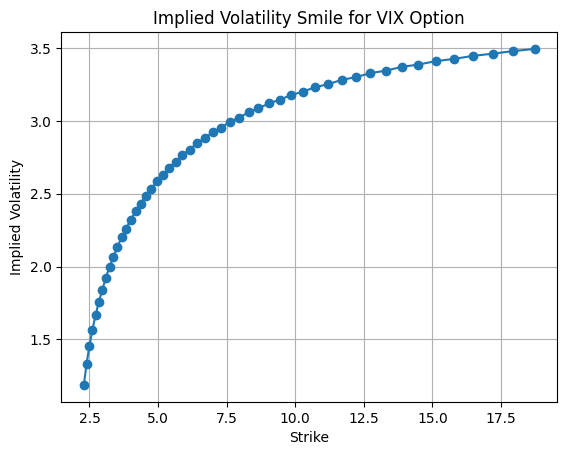

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from py_vollib.black_scholes.implied_volatility import implied_volatility as bs_iv

# === Paramètres ===
eps = 1/52
H = 0.1
a_k = [0.0004, 0.0038, 0.0004, 0.0085, 0.0005, 1]
T = 9/365
n_steps = 400
N_sims = 10000
rho = -0.85
delta = 30/365
r = 0.0

# === Exemple de courbe de forward variance constante ===

# === Exemple de courbe de forward variance constante ===
T_nodes = np.array([
    0.0001, 0.0005, 0.001 , 0.0015, 0.0055, 0.0303, 0.0552, 0.0801,
    0.105 , 0.1298, 0.1547, 0.1796, 0.2044, 0.2293, 0.2542, 0.2791,
    0.3039, 0.3288, 0.3537, 0.3785, 0.4034, 0.4283, 0.4531, 0.478 ,
    0.5029, 0.5278, 0.5526, 0.5775, 0.6024, 0.6272, 0.6521, 0.677 ,
    0.7019, 0.7267, 0.8857, 1.0447, 1.2036, 1.3626, 1.5216, 1.6805,
    1.8395, 1.9985, 2.1574
])

fv_nodes = np.array([
    0.00000023, 0.00000117, 0.00000235, 0.00000352, 0.00001286,
    0.00033119, 0.00052188, 0.00088383, 0.00126912, 0.0017979 ,
    0.00196599, 0.00270324, 0.00322654, 0.00332477, 0.00396569,
    0.00442826, 0.0048271 , 0.00615094, 0.00692078, 0.00707639,
    0.0076925 , 0.00881826, 0.00963305, 0.01002174, 0.01142226,
    0.01267608, 0.012891  , 0.013082  , 0.01361588, 0.0141797 ,
    0.01568081, 0.01668033, 0.01704239, 0.01780291, 0.02466145,
    0.03022112, 0.03537132, 0.04249715, 0.04841705, 0.05687464,
    0.0619833 , 0.06789834, 0.07726454
])



fv = interp1d(T_nodes, fv_nodes, kind='linear', fill_value="extrapolate")

# === Instanciation de la classe ===
model = VIX_One_QUINTIC(eps=eps, H=H, n_steps=n_steps, delta=delta,a_k= a_k,T=T)

# === Calcul du vecteur beta ===

model.compute_beta_vector_full(ksi_0=fv)

# === Calcul de VIX_T (forward VIX) ===
vix_T = model.compute_vix_futures()

# === Strikes à tester ===
lm_vix = np.linspace(-0.1,2,50)
K_vec = np.exp(lm_vix)
# === Calcul des prix d'options sur VIX ===
# === Calcul des prix d'options sur VIX ===
# === Calcul des prix d'options sur VIX ===
C_vec = []
for K_i in K_vec:
    Ft, price, _ = model.vix_call_price(strike_perc_vix=K_i)
    C_vec.append((Ft, price))  # stocke les deux pour IV

# === Calcul des volatilités implicites ===
IV_vec = []
for K_i in K_vec:
    Ft, price, _ = model.vix_call_price(strike_perc_vix=K_i)
    try:
        Ft = float(np.squeeze(Ft))
        price = float(np.squeeze(price))
        iv = bs_iv(price, Ft, Ft * K_i, T, r, 'c')
    except Exception as e:
        print(f"Failed to compute IV for strike={K_i}: {e}")
        iv = np.nan
    IV_vec.append(iv)

IV_vec = np.array(IV_vec)

# === Affichage de la smile ===
plt.plot(K_vec * vix_T, IV_vec, marker='o')  # x-axis = strike absolute
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title("Implied Volatility Smile for VIX Option")
plt.grid(True)
plt.show()